In [1]:
# !pip install git+https://github.com/openai/CLIP.git


In [2]:
import torch, clip
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
transform = preprocess  # CLIP’s own resize/normalize
stl10 = datasets.STL10(root="./data", split='test', download=True, transform=transform)
loader = torch.utils.data.DataLoader(stl10, batch_size=64, shuffle=False)

In [5]:
classes = stl10.classes  # ['airplane','bird',...]
# three prompt styles:
plain      = [c for c in classes]
photo      = [f"a photo of a {c}" for c in classes]
descriptive= [f"a centered photo of a small {c}, detailed" for c in classes]

def text_features(prompts):
    tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        return model.encode_text(tokens).float()


In [6]:
@torch.no_grad()
def zero_shot_accuracy(text_prompts):
    txt_feat = text_features(text_prompts)
    txt_feat /= txt_feat.norm(dim=-1, keepdim=True)

    correct, total = 0, 0
    for imgs, labels in tqdm(loader):
        imgs = imgs.to(device)
        img_feat = model.encode_image(imgs).float()
        img_feat /= img_feat.norm(dim=-1, keepdim=True)

        # cosine similarity
        logits = 100 * img_feat @ txt_feat.T
        preds = logits.argmax(dim=-1)
        correct += (preds.cpu() == labels).sum().item()
        total   += labels.size(0)

    return correct / total


In [7]:
acc_plain   = zero_shot_accuracy(plain)
acc_photo   = zero_shot_accuracy(photo)
acc_descr   = zero_shot_accuracy(descriptive)

print(f"Plain:   {acc_plain:.3f}")
print(f"Photo:   {acc_photo:.3f}")
print(f"Descr.:  {acc_descr:.3f}")


100%|██████████| 125/125 [00:26<00:00,  4.64it/s]

Plain:   0.963
Photo:   0.974
Descr.:  0.962


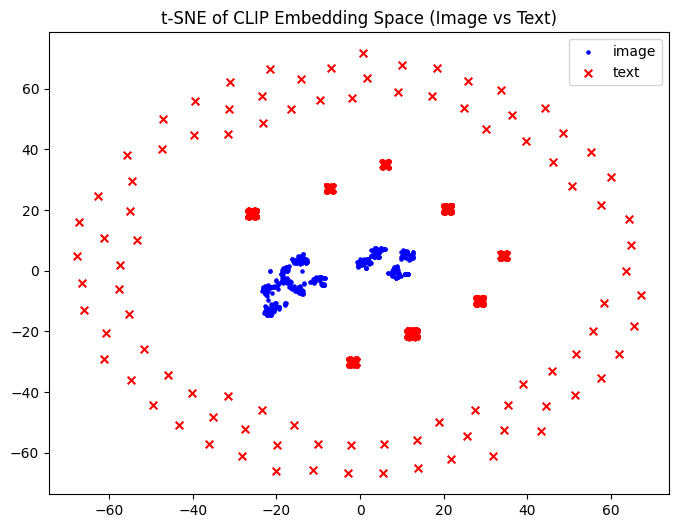

In [11]:
import torch
import clip
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# get some test images
from torchvision import datasets
stl10 = datasets.STL10("./data", split='test', download=True, transform=preprocess)
subset = torch.utils.data.Subset(stl10, range(500))   # just 500 samples
loader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=False)

# grab image features
img_feats = []
labels    = []
with torch.no_grad():
    for imgs, y in loader:
        feats = model.encode_image(imgs.to(device)).float()
        feats /= feats.norm(dim=-1, keepdim=True)
        img_feats.append(feats.cpu())
        labels.append(y)
img_feats = torch.cat(img_feats)
labels    = torch.cat(labels)

# grab text features for the same labels
classes = stl10.classes
prompts = [f"a photo of a {c}" for c in classes]
txt_tokens = clip.tokenize(prompts).to(device)
with torch.no_grad():
    txt_feats = model.encode_text(txt_tokens).float()
    txt_feats /= txt_feats.norm(dim=-1, keepdim=True)

# replicate each text vector for however many images of that class (optional)
txt_all = txt_feats[labels].cpu()

# stack & label modalities
features = torch.cat([img_feats, txt_all])
modes    = ["image"] * len(img_feats) + ["text"] * len(txt_all)

# 2-D projection
tsne = TSNE(n_components=2, init="random", learning_rate="auto")
proj = tsne.fit_transform(features.numpy())

# plot
plt.figure(figsize=(8, 6))
proj_img = proj[:len(img_feats)]
proj_txt = proj[len(img_feats):]

plt.scatter(proj_img[:, 0], proj_img[:, 1], c="blue", s=5, label="image")
plt.scatter(proj_txt[:, 0], proj_txt[:, 1], c="red",  s=30, marker="x", label="text")
plt.legend()
plt.title("t-SNE of CLIP Embedding Space (Image vs Text)")
plt.show()


In [15]:
import torch
import clip
import numpy as np
from torchvision import datasets
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# --- 1. Collect a small calibration set ---
stl10 = datasets.STL10("./data", split='train', download=True, transform=preprocess)
subset = torch.utils.data.Subset(stl10, range(500))  # just 500 samples
loader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=False)

classes = stl10.classes
prompts = [f"a photo of a {c}" for c in classes]
txt_tokens = clip.tokenize(prompts).to(device)

with torch.no_grad():
    txt_feats = model.encode_text(txt_tokens).float()
    txt_feats /= txt_feats.norm(dim=-1, keepdim=True)

# compute mean image embedding for each class
img_means = torch.zeros_like(txt_feats)
counts = torch.zeros(len(classes),device=device)

with torch.no_grad():
    for imgs, labels in loader:
        feats = model.encode_image(imgs.to(device)).float()
        feats /= feats.norm(dim=-1, keepdim=True)
        for f, l in zip(feats, labels):
            img_means[l] += f
            counts[l] += 1
img_means /= counts.unsqueeze(1)  # mean per class

# --- 2. Solve Procrustes (rotation) ---
X = txt_feats.cpu().numpy()
Y = img_means.cpu().numpy()
U, _, Vt = np.linalg.svd(X.T @ Y)  # singular value decomposition
W = U @ Vt                        # optimal orthogonal map

W = torch.from_numpy(W).float().to(device)

# --- 3. Evaluate Zero-Shot Again ---
@torch.no_grad()
def zero_shot_accuracy_with_W():
    aligned_txt = (txt_feats @ W)  # rotate text features
    aligned_txt /= aligned_txt.norm(dim=-1, keepdim=True)

    # use STL-10 test set
    test = datasets.STL10("./data", split='test', download=True, transform=preprocess)
    loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

    correct, total = 0, 0
    for imgs, labels in tqdm(loader):
        imgs = imgs.to(device)
        img_feat = model.encode_image(imgs).float()
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        logits = 100 * img_feat @ aligned_txt.T
        preds = logits.argmax(dim=-1)
        correct += (preds.cpu() == labels).sum().item()
        total   += labels.size(0)

    return correct / total

acc_aligned = zero_shot_accuracy_with_W()
print(f"Zero-shot accuracy after alignment: {acc_aligned:.3f}")


100%|██████████| 125/125 [00:20<00:00,  6.02it/s]

Zero-shot accuracy after alignment: 0.977


In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- Grab some test data ---
test = datasets.STL10("./data", split='test', download=True, transform=preprocess)
subset = torch.utils.data.Subset(test, range(500))   # just 500 samples
loader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=False)

img_feats = []
labels = []
with torch.no_grad():
    for imgs, y in loader:
        feats = model.encode_image(imgs.to(device)).float()
        feats /= feats.norm(dim=-1, keepdim=True)
        img_feats.append(feats.cpu())    # stay on CPU
        labels.append(y)
img_feats = torch.cat(img_feats)
labels = torch.cat(labels)

# text features (aligned)
aligned_txt = (txt_feats @ W).cpu()
aligned_txt /= aligned_txt.norm(dim=-1, keepdim=True)

# replicate text for each label (so one per image)
txt_all = aligned_txt[labels]


In [17]:
features = torch.cat([img_feats, txt_all])
modes = ["image"] * len(img_feats) + ["text"] * len(txt_all)

tsne = TSNE(n_components=2, init="random", learning_rate="auto")
proj = tsne.fit_transform(features.numpy())


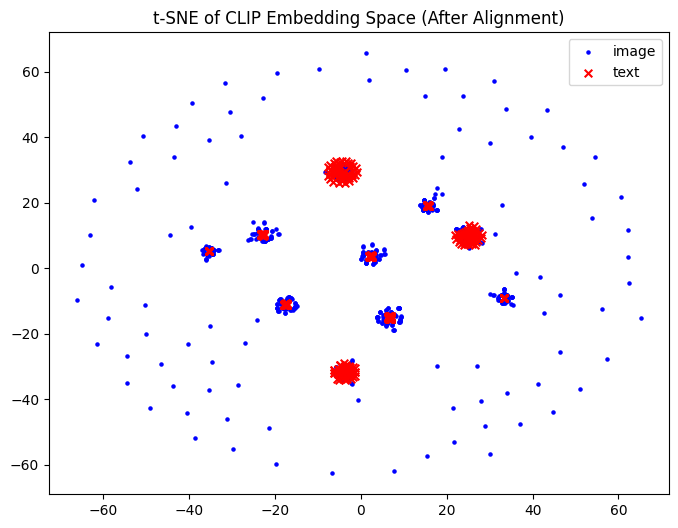

In [18]:
plt.figure(figsize=(8, 6))
proj_img = proj[:len(img_feats)]
proj_txt = proj[len(img_feats):]

plt.scatter(proj_img[:, 0], proj_img[:, 1], c="blue", s=5, label="image")
plt.scatter(proj_txt[:, 0], proj_txt[:, 1], c="red", s=30, marker="x", label="text")
plt.legend()
plt.title("t-SNE of CLIP Embedding Space (After Alignment)")
plt.show()
